In [1]:
"""
author: Yang
time: 2021.1.27
"""

from random import shuffle
from turtle import shape
from numpy import dtype
import tensorflow as tf
from utils import *
from sklearn.model_selection import KFold
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())


In [2]:
data="""1 & 90.00 & 95.00 & 85.00 & 0.804 \\
2 & 91.75 & 98.00 & 85.50 & 0.842 \\
3 & 91.00 & 96.00 & 86.00 & 0.824 \\
4 & 90.25 & 95.50 & 85.00 & 0.809 \\
5 & 90.25 & 93.00 & 87.50 & 0.806 \\
6 & 90.75 & 91.50 & 90.00 & 0.815 \\
7 & 90.00 & 95.50 & 84.50 & 0.805 \\
8 & 90.75 & 93.00 & 88.50 & 0.816 \\
9 & 89.25 & 94.00 & 84.50 & 0.789 \\
10 & 87.50 & 92.00 & 83.00 & 0.753 \\"""
data_list=data.replace("\\","").replace(" ","").split("\n")

import numpy as np
t=np.zeros(shape=(10,5))

for i in range(10):
    row_data=data_list[i].split("&")
    for j in range(0,5):
        t[i,j]=float(row_data[j])

for i in range(1,4+1):
    print("{:.3f}".format(np.std(t[:,i])),end="&")
    

1.091&1.911&2.006&0.022&

In [7]:
## 数据集1
def readTxt(file):
    with open(file,'r',encoding="utf-8") as f:
        return f.read().split("\n")

dic={'A':'A','T':'T','G':'G','C':'C'}
dic_con={'A':1,'T':2,'G':3,'C':4}

num=3
def readTxt(file):
    with open(file,'r',encoding="utf-8") as f:
        return f.read().split("\n")

non_test=readTxt("datasets/non_test.txt")
non_train=readTxt("datasets/non_train.txt")
strong_test=readTxt("datasets/strong_test.txt")
strong_train=readTxt("datasets/strong_train.txt")
weak_test=readTxt("datasets/weak_test.txt")
weak_train=readTxt("datasets/weak_train.txt")

def GenerateFromTextToNumpy(label,train):
    train_con=[]
    train_text=[]
    train_text_5=[]
    train_y=[]
    for i in train:
        
        con_t=[dic_con[key] for key in i]
        train_con.append(np.array(con_t))

        t=threeSequecne(i,4) # 化为三元组 步长为3
        train_text.append(np.array(t))

        t=threeSequecne(i,7) # 化为三元组 步长为5
        train_text_5.append(np.array(t))

        train_y.append(np.array([label]))
    train_con=np.array(train_con)
    train_text_5=np.array(train_text_5)
    train_text=np.array(train_text)
    train_y=np.array(train_y)
    return (train_con,train_text,train_y,train_text_5)


non_train_data=GenerateFromTextToNumpy(0,non_train)
strong_train_data=GenerateFromTextToNumpy(1,strong_train)
weak_train_data=GenerateFromTextToNumpy(1,weak_train)

train_text=np.concatenate((non_train_data[1],strong_train_data[1],weak_train_data[1]))
train_con=np.concatenate((non_train_data[0],strong_train_data[0],weak_train_data[0]))[:,:,np.newaxis]
train_text_5=np.concatenate((non_train_data[3],strong_train_data[3],weak_train_data[3]))

train_y=np.concatenate((non_train_data[2],strong_train_data[2],weak_train_data[2]))

def GenerateLayerOneTestData():
    non_test_data=GenerateFromTextToNumpy(0,non_test)
    strong_test_data=GenerateFromTextToNumpy(1,strong_test)
    weak_test_data=GenerateFromTextToNumpy(1,weak_test)
    test_x={"con":np.concatenate((non_test_data[0],strong_test_data[0],weak_test_data[0]))[:,:,np.newaxis],"text":np.concatenate((non_test_data[1],strong_test_data[1],weak_test_data[1])),"text_5":np.concatenate((non_test_data[3],strong_test_data[3],weak_test_data[3]))}
    test_y=np.concatenate((non_test_data[2],strong_test_data[2],weak_test_data[2]))
    return test_x,test_y

test_x,test_y=GenerateLayerOneTestData()

po_test=test_x.copy()
po_test["con"]=po_test["con"][0:200]
po_test["text"]=po_test["text"][0:200]
po_test["text_5"]=po_test["text"][0:200]
ne_test=test_x.copy()
ne_test["con"]=ne_test["con"][200:]
ne_test["text"]=ne_test["text"][200:]
ne_test["text_5"]=ne_test["text_5"][200:]

def returnAccuracy():
    import math
    TP=self_evaluate(po_test,test_y[0:200])
    TN=self_evaluate(ne_test,test_y[200:])
    FP=1-TN
    FN=1-TP
    SN=TP/(TP+FN)
    SP=TN/(TN+FP)
    ACC=(TP+TN)/(TP+TN+FN+FP)
    try:
        MCC=(TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    except:
        MCC=-1
    text={"ACC":ACC,"SP":SP,"SN":SN,"MCC":MCC}
    return text


In [3]:
def self_evaluate(x,y):
    res=tf.nn.sigmoid(model.predict(x))  
    res=np.array(res)
    res[res>=0.5]=1
    res[res<0.5]=0
    sum=0
    correct=0
    for i,j in zip(res,y):
        sum+=1
        if i==j:
            correct+=1
    return correct/sum


In [4]:
## 数据集2
def readTxt(file):
    with open(file,'r',encoding="utf-8") as f:
        return f.read().split("\n")

dic={'A':'A','T':'T','G':'G','C':'C','N':"N"}
dic_con={'A':1,'T':2,'G':3,'C':4,'N':0}

num=3
def readTxt(file):
    with open(file,'r',encoding="utf-8") as f:
        return f.read().split("\n")

enhancer_file="datasets/fileTrain06_1.fa"
file=open(enhancer_file,"r",encoding="utf-8")
po_list=[]
ne_list=[]
lines=file.read().split()
for i in range(0,len(lines),2):
    name=lines[i]
    dna=lines[i+1]
    if name[-2:]=='po':
        po_list.append(dna)
    else:
        ne_list.append(dna)

for i in range(len(po_list)):
    po_list[i]=po_list[i][0:699]
    # if len(po_list[i])!=699:
    #     print(len(ne_list[i]))

for i in range(len(ne_list)):
    ne_list[i]=ne_list[i][0:699]
    
    if len(ne_list[i])!=699:
        nums='N'*(699-len(ne_list[i]))
        ne_list[i]+=nums

    
def GenerateFromTextToNumpy(label,train):
    train_con=[]
    train_text=[]
    train_text_5=[]
    train_y=[]
    for i in train:
        
        con_t=[dic_con[key] for key in i]
        train_con.append(np.array(con_t))

        t=threeSequecne(i,4) # 化为三元组 步长为3
        train_text.append(np.array(t))

        t=threeSequecne(i,7) # 化为三元组 步长为5
        train_text_5.append(np.array(t))

        train_y.append(np.array([label]))
    train_con=np.array(train_con)
    train_text_5=np.array(train_text_5)
    train_text=np.array(train_text)
    train_y=np.array(train_y)
    return (train_con,train_text,train_y,train_text_5)


ne_train_data=GenerateFromTextToNumpy(0,ne_list)
po_train_data=GenerateFromTextToNumpy(1,po_list)

train_text=np.concatenate((ne_train_data[1],po_train_data[1]))
train_con=np.concatenate((ne_train_data[0],po_train_data[0]))[:,:,np.newaxis]
train_text_5=np.concatenate((ne_train_data[3],po_train_data[3]))

train_y=np.concatenate((ne_train_data[2],po_train_data[2]))


def GenerateLayerOneTestData():
    enhancer_file="datasets/fileTest06_1.fa"
    file=open(enhancer_file,"r",encoding="utf-8")
    po_list=[]
    ne_list=[]
    lines=file.read().split()
    for i in range(0,len(lines),2):
        name=lines[i]
        dna=lines[i+1]
        if name[-2:]=='po':
            po_list.append(dna)
        else:
            ne_list.append(dna)

    for i in range(len(po_list)):
        po_list[i]=po_list[i][0:699]
        if len(po_list[i])!=699:
            print(len(ne_list[i]))

    for i in range(len(ne_list)):
        ne_list[i]=ne_list[i][0:699]
        
        if len(ne_list[i])!=699:
            nums='N'*(699-len(ne_list[i]))
            ne_list[i]+=nums

    ne_data=GenerateFromTextToNumpy(0,ne_list)
    po_data=GenerateFromTextToNumpy(1,po_list)

    test_x={"con":np.concatenate((ne_data[0],po_data[0]))[:,:,np.newaxis],"text":np.concatenate((ne_data[1],po_data[1])),"text_5":np.concatenate((ne_data[3],po_data[3]))}
    test_y=np.concatenate((ne_data[2],po_data[2]))
    return test_x,test_y

test_x,test_y=GenerateLayerOneTestData()
po_test=test_x.copy()
po_test["con"]=po_test["con"][0:1578]
po_test["text"]=po_test["text"][0:1578]
po_test["text_5"]=po_test["text"][0:1578]
ne_test=test_x.copy()
ne_test["con"]=ne_test["con"][1578:]
ne_test["text"]=ne_test["text"][1578:]
ne_test["text_5"]=ne_test["text_5"][1578:]
def returnAccuracy():
    import math
    TP=self_evaluate(po_test,test_y[0:1578])
    TN=self_evaluate(ne_test,test_y[1578:])
    FP=1-TN
    FN=1-TP
    SN=TP/(TP+FN)
    SP=TN/(TN+FP)
    ACC=(TP+TN)/(TP+TN+FN+FP)
    try:
        MCC=(TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    except:
        MCC=-1
    text={"ACC":ACC,"SP":SP,"SN":SN,"MCC":MCC}
    return text

In [11]:
import math
TP=0.787
TN=0.793
FP=1-TN
FN=1-TP
SN=TP/(TP+FN)
SP=TN/(TN+FP)
ACC=(TP+TN)/(TP+TN+FN+FP)
MCC=(TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
text={"ACC":ACC,"SP":SP,"SN":SN,"MCC":MCC}
text

{'ACC': 0.79, 'SP': 0.793, 'SN': 0.787, 'MCC': 0.5800104402818885}

In [8]:
kf=KFold(n_splits=10,shuffle=True,random_state=5)

t=kf.split(train_text)

index_list=[(i[0],i[1]) for i in t]

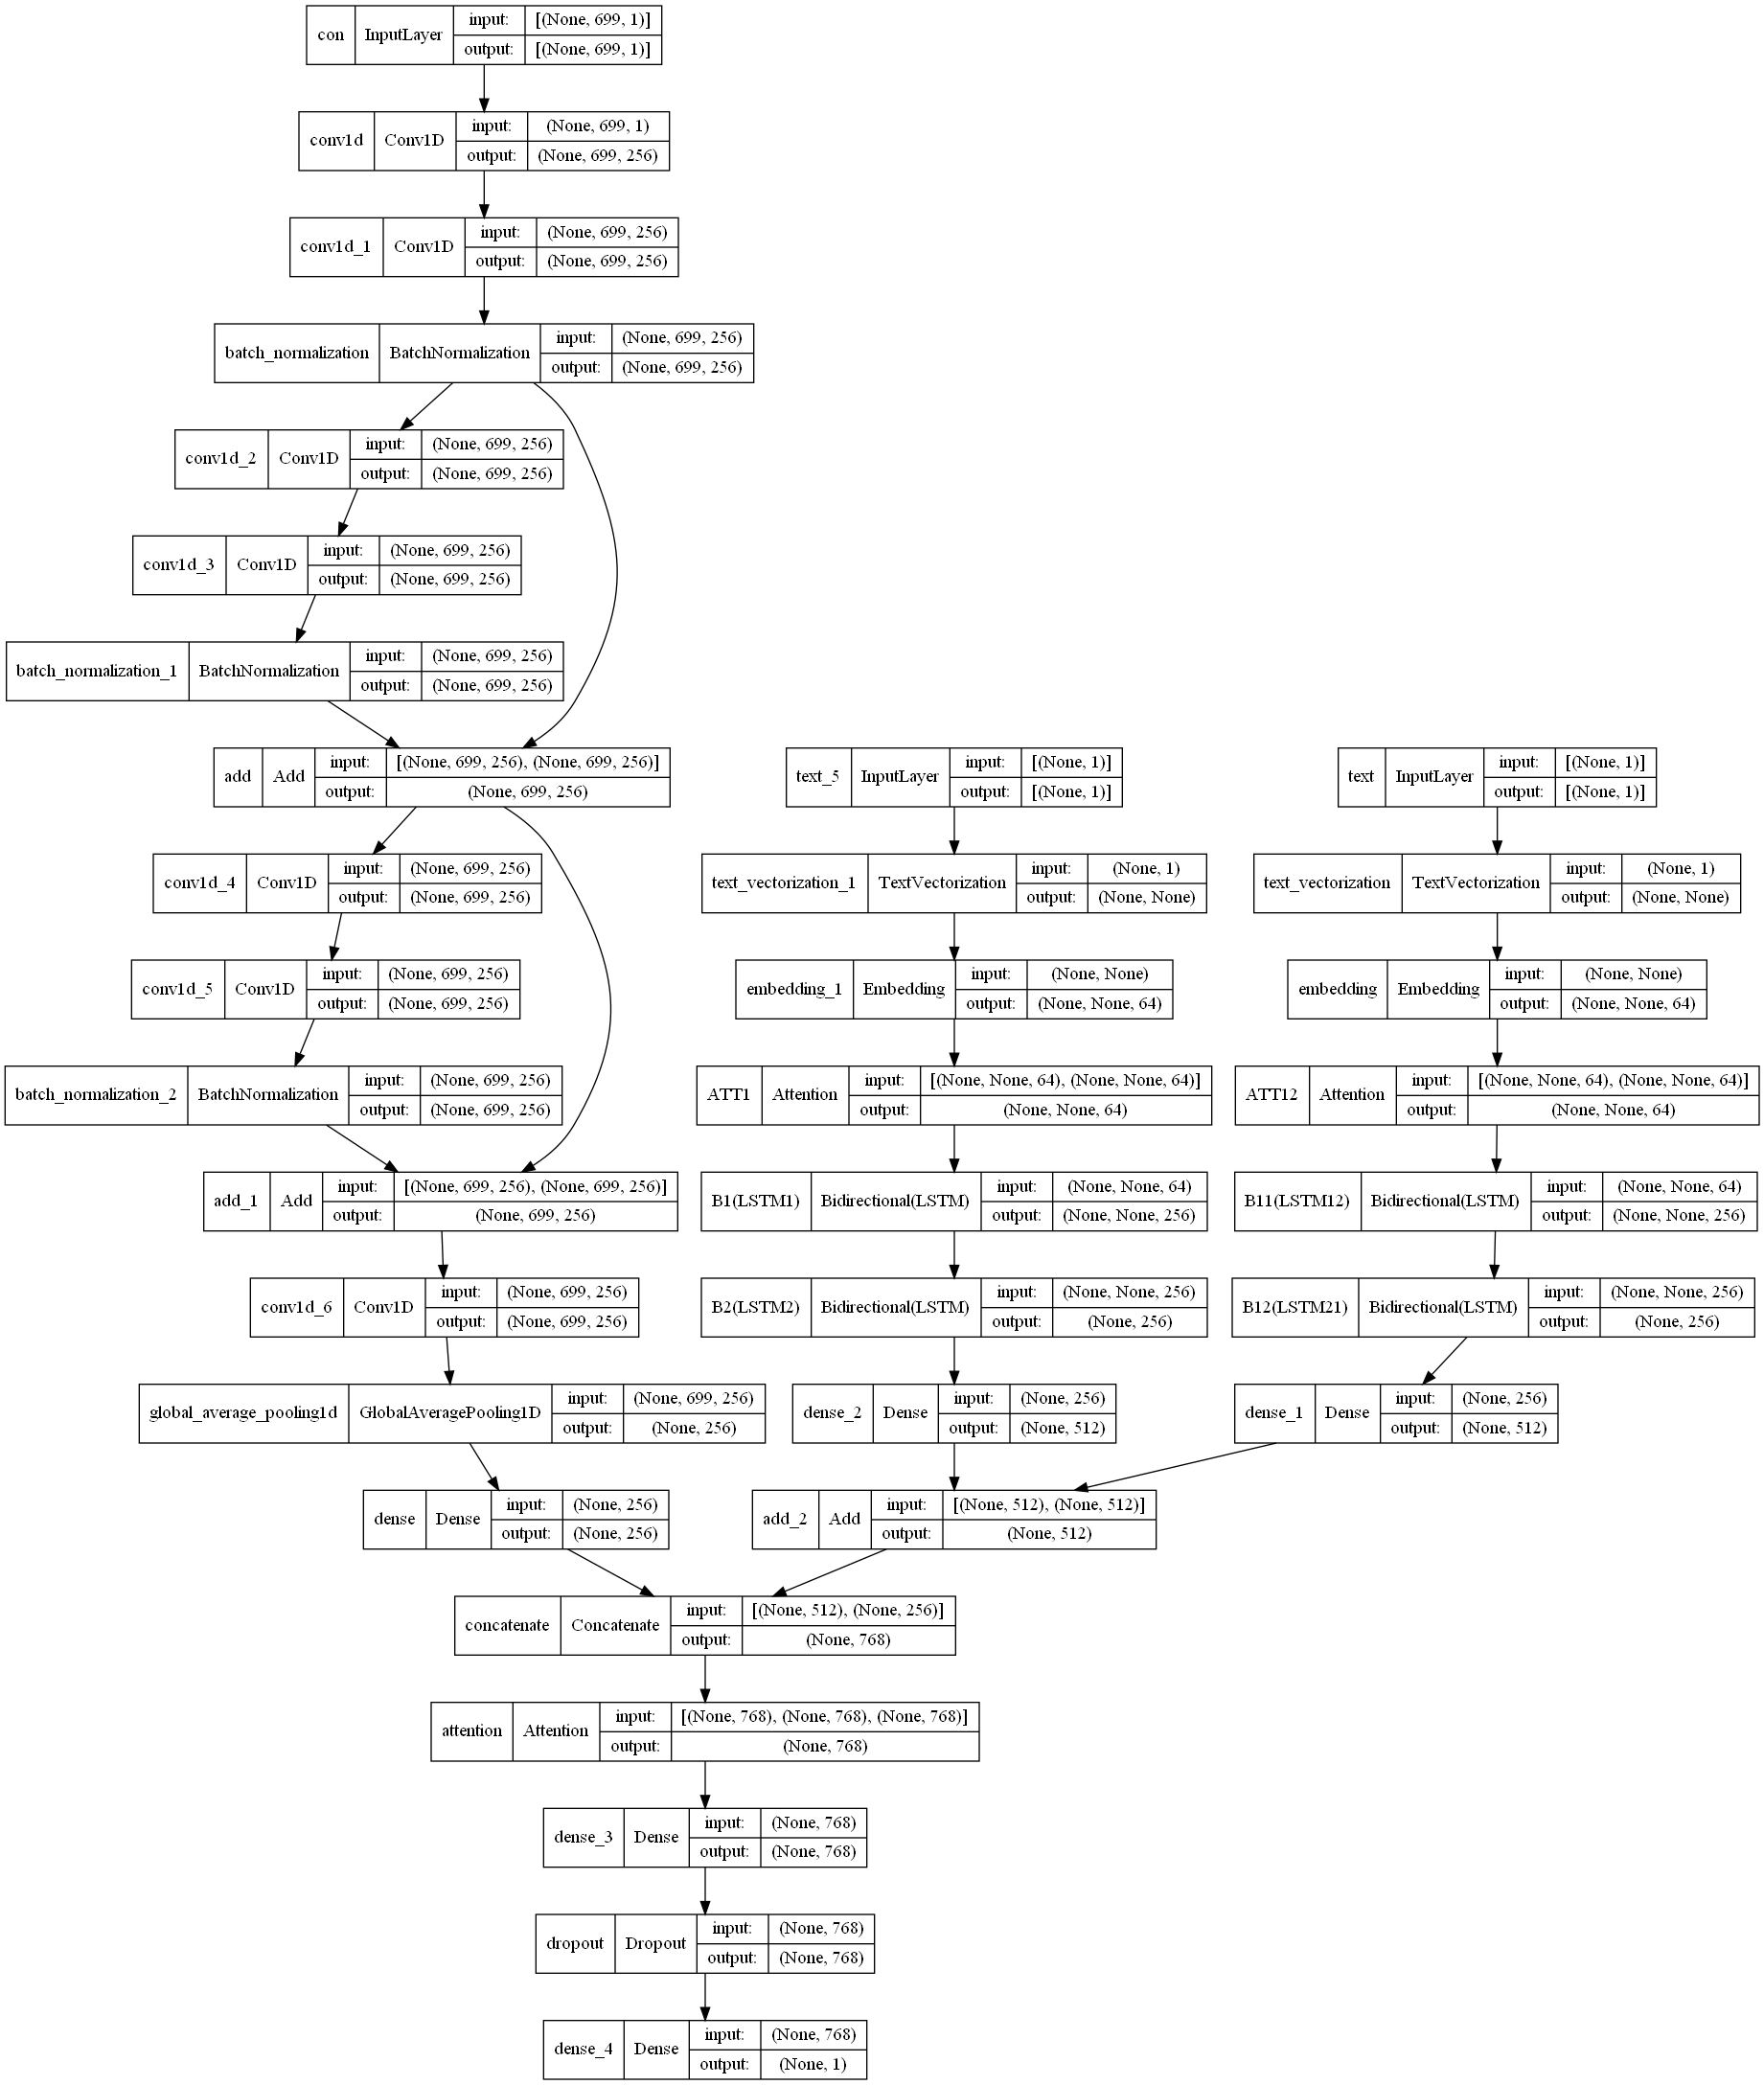

In [6]:
def load_model():
        global encoder
        kernel_num=256
        kernel_size_1=1
        kernel_size_2=2
        kernel_size_3=3
        input_con=tf.keras.Input(shape=(699,1),name='con')
        y=tf.keras.layers.Conv1D(kernel_num,kernel_size=kernel_size_1,strides=1,padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_con)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_1,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        
        block1_output=tf.keras.layers.BatchNormalization()(y)

        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_2,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(block1_output)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_2,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)

        y=tf.keras.layers.BatchNormalization()(y)
        
        block2_output=tf.keras.layers.add([y,block1_output])

        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(block2_output)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        y=tf.keras.layers.BatchNormalization()(y)
        
        block3_output=tf.keras.layers.add([y,block2_output])
        

        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(block3_output)

        y=tf.keras.layers.GlobalAveragePooling1D()(y)
        y=tf.keras.layers.Dense(256,activation='relu')(y)
 
        input_text=tf.keras.Input(shape=(1,),dtype='string',name="text")
        encoder=tf.keras.layers.TextVectorization(max_tokens=100)
        encoder.adapt(train_text)
        x=encoder(input_text)

        x=tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)(x)
        x=tf.keras.layers.Attention(name="ATT12")([x,x])
        x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True,name="LSTM12"),name="B11")(x)
        x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,name="LSTM21"),name="B12")(x)
        x=tf.keras.layers.Dense(512,activation='relu')(x)

        input_text_5=tf.keras.Input(shape=(1,),dtype='string',name="text_5")
        encoder_5=tf.keras.layers.TextVectorization(max_tokens=100)
        encoder_5.adapt(train_text_5)
        z=encoder_5(input_text_5)

        z=tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)(z)
        z=tf.keras.layers.Attention(name="ATT1")([z,z])
        z=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True,name="LSTM1"),name="B1")(z)
        z=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,name="LSTM2"),name="B2")(z)
        z=tf.keras.layers.Dense(512,activation='relu')(z)

        x=tf.keras.layers.add([z,x])

        feature_layer=tf.keras.layers.concatenate([x,y])

        att=tf.keras.layers.Attention()([feature_layer,feature_layer,feature_layer])

        d=tf.keras.layers.Dense(768,activation='relu')(att)
        d=tf.keras.layers.Dropout(0.1)(d)
        output=tf.keras.layers.Dense(1)(d)
        model=tf.keras.Model([input_text_5,input_text,input_con],output)
        base_learning_rate = 0.001
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
        return model
model=load_model()
tf.keras.utils.plot_model(model,show_shapes=True)

In [9]:
def train(index):
    callback = tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss')

    epochs=120
    TRAIN_ACC=0
    MAX_ACC=0
    loss=100
    text={}
    val_acc=0
    for i in range(epochs):
        
        if i<30:
            lr=0.001
        elif i<80:
            lr=0.0005
        else:
            lr=0.0001
            
        def scheduler(epoch):
            # 前5个epoch学习率保持不变，5个epoch后学习率按比例衰减
            return lr
        reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
        print(f"index:{index},epochs:{i}")
        history=model.fit(each_fold_train_x,each_fold_train_y,shuffle=True,epochs=1,validation_data=(each_fold_val_x,each_fold_val_y),batch_size=128,callbacks=[reduce_lr])

        if history.history["val_loss"][0]<loss:
            
            loss=history.history["val_loss"][0]
            text=returnAccuracy()
            text["val_acc"]=self_evaluate(each_fold_val_x,each_fold_val_y)
        print(text,val_acc)
    record.append(text) 

In [23]:
returnAccuracy()

{'ACC': 0.5, 'SP': 1.0, 'SN': 0.0, 'MCC': -1}

In [8]:
name="layer1_Fuse"

In [ ]:
record=[]

for i in range(0,10):
    fold_order=i
    (train_index,val_index)=index_list[fold_order]
    each_fold_train_x={"con":train_con[train_index],"text":train_text[train_index],"text_5":train_text_5[train_index]}
    each_fold_train_y=train_y[train_index]
    each_fold_val_x={"con":train_con[val_index],"text":train_text[val_index],"text_5":train_text_5[val_index]}
    each_fold_val_y=train_y[val_index]
    model=load_model()
    train(i)
    #model.save_weights(f"checkpoint\{name}_{i}")

print(record)

In [ ]:
train_acc=[]
val_acc=[]
test_acc=[]
record=[]                                                                                      
for i in range(10):
    fold_order=i
    (train_index,val_index)=index_list[fold_order]
    each_fold_train_x={"con":train_con[train_index],"text":train_text[train_index],"text_5":train_text_5[train_index]}
    each_fold_train_y=train_y[train_index]
    each_fold_val_x={"con":train_con[val_index],"text":train_text[val_index],"text_5":train_text_5[val_index]}
    each_fold_val_y=train_y[val_index]
    model=load_model()
    model.load_weights(f"checkpoint\{name}_{i}")
    print(i)
    train_acc.append(self_evaluate(each_fold_train_x,each_fold_train_y))
    val_acc.append(self_evaluate(each_fold_val_x,each_fold_val_y))
    
    text=returnAccuracy()
    test_acc.append(text['ACC'])
    record.append(text) 
    print("------")



In [47]:
print("train_acc | evaluate_acc | test_acc")
for index in range(10):
    print(f"{int(train_acc[index]*10000)/100}           {int(val_acc[index]*10000)/100}      {int(test_acc[index]*10000)/100}")

train_acc | evaluate_acc | test_acc
95.91           92.59      94.5
95.65           88.21      93.75
94.68           88.88      89.5
96.1           94.27      94.5
94.38           90.57      91.25
92.54           97.97      89.75
94.0           95.95      93.5
96.78           92.25      92.5
87.42           89.86      87.25
90.23           92.9      90.5


In [15]:
ACC=0
SP=0
SN=0
MCC=0
VAL_ACC=0
for i in record:
    ACC+=i["ACC"]
    SP+=i["SP"]
    SN+=i["SN"]
    MCC+=i["MCC"]

ACC/=10
SP/=10
SN/=10
MCC/=10
VAL_ACC/=10
text={"ACC":ACC,"SP":SP,"SN":SN,"MCC":MCC,"VAL_ACC":VAL_ACC}
print(text)

{'ACC': 0.92925, 'SP': 0.885, 'SN': 0.9734999999999999, 'MCC': 0.8621306985234363, 'VAL_ACC': 0.0}


In [ ]:
{'ACC': 0.9319999999999998, 'SP': 0.897, 'SN': 0.967, 'MCC': 0.8664745872342102, 'VAL_ACC': 0.0} 4+local
{'ACC': 0.92925, 'SP': 0.885, 'SN': 0.9734999999999999, 'MCC': 0.8621306985234363, 'VAL_ACC': 0.0} 7+local

In [23]:
count=0
for index,i in enumerate(record):
    
    #VAL_ACC="{:.2f}".format(i['val_acc']*100)
    ACC="{:.2f}".format(i['ACC']*100)
    SP="{:.2f}".format(i['SP']*100)
    SN="{:.2f}".format(i['SN']*100)
    MCC="{:.3f}".format(i['MCC'])

    text=f"{index+1} & {ACC} & {VAL_ACC} & {SP} & {SN} & {MCC} \\\\"
    print(text)
    count+=1

ACC=0
SP=0
SN=0
MCC=0
VAL_ACC=0
for i in record:
    try:
        ACC+=i["ACC"]
        SP+=i["SP"]
        SN+=i["SN"]
        MCC+=i["MCC"]
        #VAL_ACC+=i['val_acc']
    except:
        pass

ACC/=count
SP/=count
SN/=count
MCC/=count
VAL_ACC/=count
ACC="{:.2f}".format(ACC*100)
VAL_ACC="{:.2f}".format(VAL_ACC*100)
SP="{:.2f}".format(SP*100)
SN="{:.2f}".format(SN*100)
MCC="{:.3f}".format(MCC)
text=f"Mean & {ACC} & {VAL_ACC} & {SP} & {SN} & {MCC} \\\\"
print(text)

1 & 94.50 & 0 & 98.00 & 91.00 & 0.892 \\
2 & 93.75 & 0 & 98.00 & 89.50 & 0.878 \\
3 & 89.50 & 0 & 89.50 & 89.50 & 0.790 \\
4 & 94.50 & 0 & 98.00 & 91.00 & 0.892 \\
5 & 91.25 & 0 & 98.00 & 84.50 & 0.833 \\
6 & 89.75 & 0 & 87.00 & 92.50 & 0.796 \\
7 & 93.50 & 0 & 91.00 & 96.00 & 0.871 \\
8 & 92.50 & 0 & 94.00 & 91.00 & 0.850 \\
9 & 87.25 & 0 & 99.00 & 75.50 & 0.766 \\
10 & 90.50 & 0 & 98.00 & 83.00 & 0.819 \\
Mean & 91.70 & 0.00 & 95.05 & 88.35 & 0.839 \\


In [66]:
name=r"checkpoint\fuse_0"
model.load_weights(name)